In [ ]:
from openai import OpenAI
import os
import base64
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=24)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    
    plt.axis("off")
    plt.imshow(img)
    
    


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    plt.axis("off")
    plt.imshow(img)
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  plt.axis("off")
  plt.imshow(img)
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output



def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

####################### replace your api key here ###################
client = OpenAI(
    api_key='', 
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

In [26]:
min_pixels = 512*28*28
max_pixels = 2048*28*28


base64_image = encode_image("assets/pic1.PNG")

completion = client.chat.completions.create(
    model="qwen-vl-max-latest",
    messages=[
    	{
    	    "role": "system",
            "content": [{"type":"text","text": "You are a helpful assistant."}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    "image_url": {"url": f"data:assets/png;base64,{base64_image}"}, 
                },
                {"type": "text", "text": "detect the door, provide the bounding box"},
            ],
        }
    ],
)
print(completion.choices[0].message.content)
response = completion.choices[0].message.content

```json
[
	{"bbox_2d": [435, 389, 531, 600], "label": "door"}
]
```


(1280, 955)


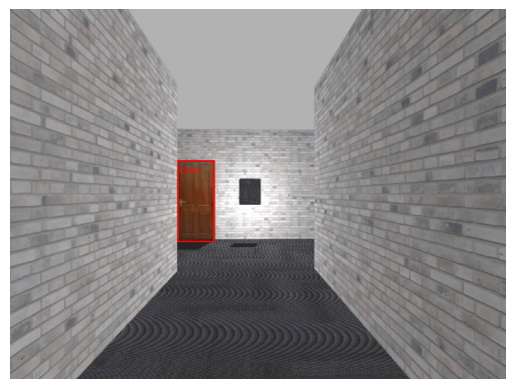

In [29]:
from qwen_vl_utils import smart_resize

image_path = "./assets/pic1.PNG"
image = Image.open(image_path)
width, height = image.size
input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
plot_bounding_boxes(image, response, input_width, input_height)

# Multiple rounds of dialogue (refer to historical dialogue information)

1st round：Based on the current image, there are no visible signs or identifiers for Room 407. The corridor appears to be empty except for a door and a small window-like feature on the wall. Since the room number is not visible, we need to adjust the drone's position to get a better view of the area around the door.

### Suggested Movement Command:
- **delta_x = 1.5 meters**: Move forward slightly to get closer to the door.
- **delta_y = 0 meters**: Maintain the current lateral position.
- **delta_z = 0 meters**: Maintain the current altitude.
- **delta_yaw = 0 radians**: Keep the current orientation.

### Rationale:
- Moving forward will allow us to inspect the door more closely and check if there is any sign or identifier near it that might indicate Room 407.
- If after this movement, the room number is still not visible, we can consider rotating the drone (using delta_yaw) to look at adjacent walls or areas that might have additional clues.

After executing this command, carefully ob

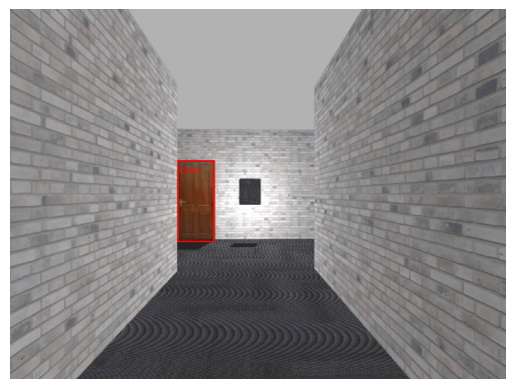

In [30]:
messages=[
    	{
    	    "role": "system",
            "content": [{"type":"text","text": "You are a helpful assistant."}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    "image_url": {"url": f"data:assets/png;base64,{base64_image}"}, 
                },
                {"type": "text", "text": "You are controlling a drone inside a school office building.  Your objective: Guide the drone to the entrance of Room 407.  Important requirements: 1. The drone must actively search for room signs or any other identifiers (e.g., corridor signs, office nameplates).  2. If the sign or room number is partially or completely obscured, instruct the drone to adjust its position or yaw to obtain a clearer view. 3. Use small, incremental movements (Observation-Based Control) to avoid collisions, especially near glass walls or narrow corridors. 4. After each movement, carefully observe the updated camera feed for new indicators or obstacles. 5. Once you think you see the correct room (407), instruct the drone to perform a final check by hovering close enough to read the sign. If the sign is still not visible or the number is unclear, continue searching or try an alternative viewpoint. 6. If recognition remains ambiguous, try capturing a photo to confirm with an operator or look for adjacent rooms to cross-verify location.  Your control format (body frame, incremental moves): Observation-Based Control (delta_x, delta_y, delta_z, delta_yaw)  - delta_x, delta_y, delta_z ∈ [-3, 3] (in meters) - delta_yaw ∈ [-3.14, 3.14] (in radians) - Right-hand rule for both body and world coordinate systems.  Now, look at the current camera feed:  Image is attached  Based on the image, provide the next movement command to approach or identify Room 407. If you cannot see any sign or the sign is unclear, consider rotating or shifting the drone for a better view."},
            ],
        }
    ]

completion = client.chat.completions.create(
    model="qwen-vl-max-latest",
    messages=messages,
    )
print(f"1st round：{completion.choices[0].message.content}")
assistant_message = completion.choices[0].message
messages.append(assistant_message.model_dump())
messages.append({
        "role": "user",
        "content": [
        {
            "type": "text",
            "text": "localize the door"
        }
        ]
    })
completion = client.chat.completions.create(
    model="qwen-vl-max-latest",
    messages=messages,
    )
print(f"2nd round：{completion.choices[0].message.content}")

image_path = "./assets/pic1.PNG"
image = Image.open(image_path)
width, height = image.size
input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
plot_bounding_boxes(image, response, input_width, input_height)